In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.integrate import quad
import os, sys
from astropy import units as u, constants as cst

%matplotlib ipympl

In [2]:
sys.path.append(os.getcwd() + '/../camb')
import utils as ut
import props as p
import lines as l
from importlib import reload
p = reload(p)

from astropy.cosmology import Planck18 as cosmo
H0 = cosmo.H0.value
h = cosmo.h
lilh = False

TIM = p.TIM
FYST = p.FYST
LADUMA = p.LADUMA

# TIM.Daz = 1 * u.deg 
# TIM.Del = 10 * u.deg
# TIM.SW.dnu = TIM.SW.dnu / 5
# TIM.LW.dnu = TIM.LW.dnu / 5

In [3]:
# TIM
bins = [
    ut.zBin(TIM.SW.zmin, TIM.SW.zcen),
    ut.zBin(TIM.SW.zcen, TIM.SW.zmax),
    ut.zBin(TIM.LW.zmin, TIM.LW.zcen),
    ut.zBin(TIM.LW.zcen, TIM.LW.zmax),
]
bands = ['SW', 'SW', 'LW', 'LW']

LSbins = [ut.Survey(b, TIM[band].ins, TIM.Daz, TIM.Del, lilh) for b, band in zip(bins, bands)]

In [4]:
[print(b.center) for b in bins];

0.6435273234436414
0.8875998478508937
1.1728794218333967
1.4993660453911497


In [5]:
k_xyz_modes = [lsb.k_modes() for lsb in LSbins]
# k_xyz_modes[N] where N is the survey bin
# each element is a 4D array of shape (3, Nkx, Nky, Nkz)

k_mags = [np.sqrt(np.sum(kxyzs**2, axis=0)) for kxyzs in k_xyz_modes] 
k_mins = [np.min(km[km != 0]) for km in k_mags]
k_maxs = [np.max(km) for km in k_mags]
k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]

# parallel and perpendicular components
k_para = [np.abs(kxyzs[2]) for kxyzs in k_xyz_modes]
k_perp = [np.sqrt(kxyzs[0]**2 + kxyzs[1]**2) for kxyzs in k_xyz_modes]
kxs = [kxyzs[0] for kxyzs in k_xyz_modes]
kys = [kxyzs[1] for kxyzs in k_xyz_modes]
kzs = [kxyzs[2] for kxyzs in k_xyz_modes]

kxmins = [np.min(abs(kx[kx != 0])) for kx in kxs]
kxmaxs = [np.max(abs(kx)) for kx in kxs]
kymins = [np.min(abs(ky[ky != 0])) for ky in kys]
kymaxs = [np.max(abs(ky)) for ky in kys]
kzmins = [np.min(abs(kz[kz != 0])) for kz in kzs]
kzmaxs = [np.max(abs(kz)) for kz in kzs]

# mu = cos theta
mu = muz = [kxyzs[2] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
mux = [kxyzs[0] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
muy = [kxyzs[1] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_40570/4261512376.py:8: RuntimeWarning: invalid value encountered in divide
  k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_40570/4261512376.py:25: RuntimeWarning: invalid value encountered in divide
  mu = muz = [kxyzs[2] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_40570/4261512376.py:26: RuntimeWarning: invalid value encountered in divide
  mux = [kxyzs[0] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_40570/4261512376.py:27: RuntimeWarning: invalid value encountered in divide
  muy = [kxyzs[1] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]


/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_40570/4051381368.py:17: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(kxs[i][mask], kys[i][mask], kzs[i][mask], s=1, alpha=.5, marker='x', \


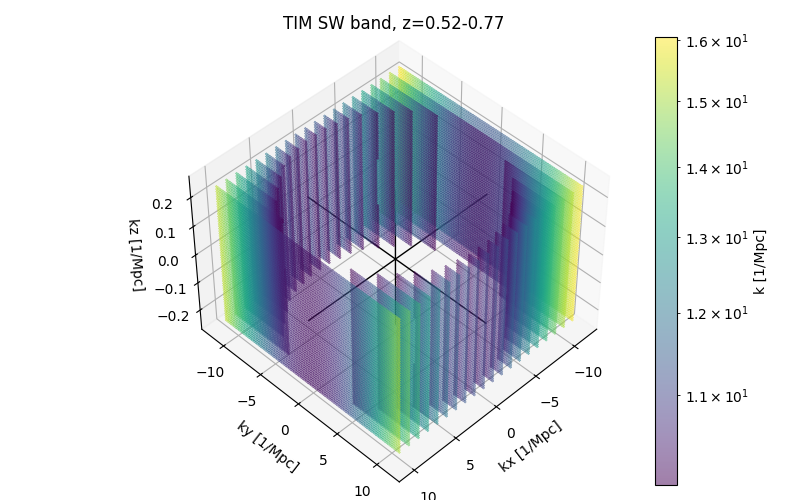

In [6]:
# make a 3d scatter plot of the k-modes

equal_axes = False
plot_axes = True

def isclose(arr, val, atol):
    return np.isclose(val, arr, atol=atol)

fig, axs = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8, 5))
for i, ax in enumerate(np.atleast_1d(axs).flatten()):
    mask = True
    # mask = (kzs[i] == 0) | (kxs[i] == 0) | (kys[i] == 0)
    # mask = (isclose(kzs[i], 0, kzmins[i] / 2)) | \
    #     ((isclose(kxs[i], 0, kxmins[i] / 2)) & (isclose(kys[i], 0, kymins[i] / 2)))
    mask = k_mags[i] > 1e1

    ax.scatter(kxs[i][mask], kys[i][mask], kzs[i][mask], s=1, alpha=.5, marker='x', \
        cmap='viridis', c=k_mags[i][mask], edgecolor='none', norm=plt.cm.colors.LogNorm())
    # plot the axes
    if plot_axes:
        ax.plot([np.nanmin(kxs[i]), np.nanmax(kxs[i])], [0, 0], [0, 0], c='k', linewidth=1)
        ax.plot([0, 0], [np.nanmin(kys[i]), np.nanmax(kys[i])], [0, 0], c='k', linewidth=1)
        ax.plot([0, 0], [0, 0], [np.nanmin(kzs[i]), np.nanmax(kzs[i])], c='k', linewidth=1)
    ax.set_title(f'TIM {bands[i]} band, z={bins[i].front:.2f}-{bins[i].back:.2f}')
    ax.set_xlabel('kx [1/Mpc]')
    ax.set_ylabel('ky [1/Mpc]')
    ax.set_zlabel('kz [1/Mpc]')
    if equal_axes:
        ax.set_xlim([np.nanmin(kxs[i]), np.nanmax(kxs[i])])
        ax.set_ylim([np.nanmin(kxs[i]), np.nanmax(kxs[i])])
        ax.set_zlim([np.nanmin(kxs[i]), np.nanmax(kxs[i])])
    plt.colorbar(ax.collections[0], ax=ax, label='k [1/Mpc]', orientation='vertical')
    
    ax.view_init(elev=45, azim=45)
    
plt.tight_layout()
plt.show()
# plt.close()

In [30]:
(240 - ((240+317)/2))/(((240+317)/2) / 250)

-34.56014362657091

In [31]:
[(np.array(k_xyz_modes[i].shape) - 1) // 2 for i in range(len(k_xyz_modes))]

[array([  1,  50, 513,  28], dtype=int32),
 array([  1,  50, 513,  21], dtype=int32),
 array([  1,  38, 387,  29], dtype=int32),
 array([  1,  38, 387,  21], dtype=int32)]

In [32]:
def sig_xy(z, insFWHM):
    sigbeam = insFWHM.to(u.rad).value / np.sqrt(8 * np.log(2))
    return (cosmo.comoving_distance(z) * sigbeam).to(u.Mpc).value

def sig_z(z, insdnu, linenu):
    return (cst.c / cosmo.H(z) * insdnu / linenu * (1 + z) ** 2).to(u.Mpc).value / np.sqrt(8 * np.log(2))

def L_z(z, insmin, insmax, linenu):
    if insmin.unit.is_equivalent(u.m):
        insmin = cst.c / insmin
        insmax = cst.c / insmax
    Dnu = np.abs(insmax - insmin)
    return (cst.c / cosmo.H(z) * Dnu / linenu * (1 + z) ** 2).to(u.Mpc).value

def L_xy(z, insAng):    
    return ((cosmo.comoving_distance(z) * insAng.to(u.rad).value)).to(u.Mpc).value

def kminz(z, insmin, insmax, linenu):
    return 2 * np.pi / L_z(z, insmin, insmax, linenu)

def kminxy(z, insAng):
    return 2 * np.pi / L_xy(z, insAng)

In [33]:
def wbeam_m(km, sigm):
    return np.exp(-0.5 * (km * sigm)**2)

def wbeam(ks, sigs):
    return np.prod([wbeam_m(k, s) for k, s in zip(ks, sigs)], axis=0)

def whpf_m(km, km_min):
    return (1 - np.exp(- (km/km_min) ** 2)) ** 0.5

def whpf(ks, km_mins):
    return np.prod([whpf_m(k, km_min) for k, km_min in zip(ks, km_mins)], axis=0)

In [34]:
insFWHMs = [TIM[band].FWHM for band in bands]
insAng_x, insAng_y = TIM.Daz, TIM.Del
insmins = [TIM[band].min for band in bands]
insmaxs = [TIM[band].max for band in bands]
insdnu = [TIM[band].dnu for band in bands]
linenu = l.CII.nu
CALCZs = [b.center for b in bins]

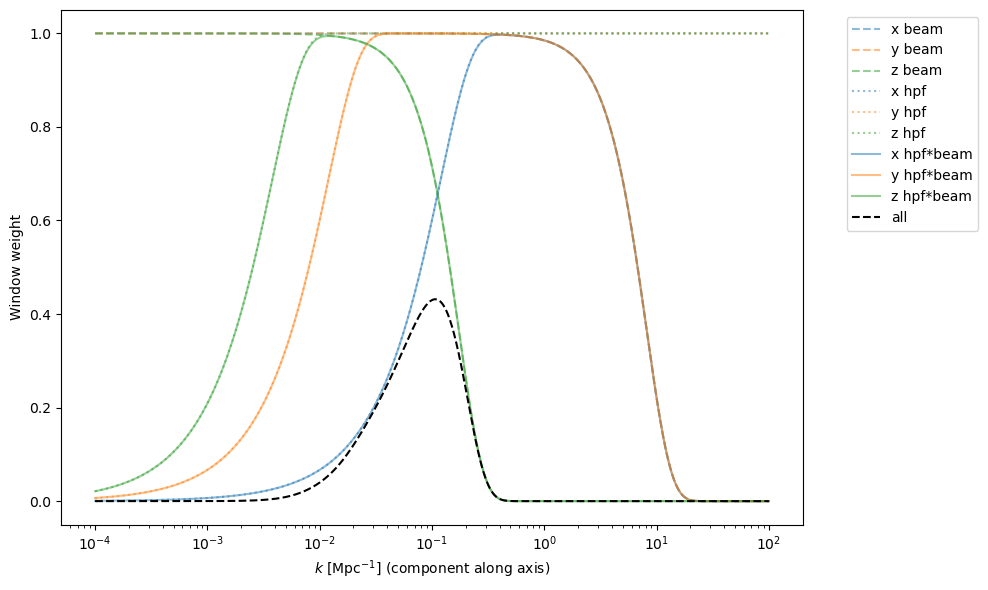

In [35]:
ks = np.logspace(-4, 2, 1000)
colors = ['C0', 'C1', 'C2',]
lss = ['--', ':', '-']
plt.figure(figsize=(10, 6))
plt.plot(ks, wbeam_m(ks, sig_xy(CALCZs[0], insFWHMs[0])), label='x beam', color=colors[0], ls=lss[0], alpha=0.5)
plt.plot(ks, wbeam_m(ks, sig_xy(CALCZs[0], insFWHMs[0])), label='y beam', color=colors[1], ls=lss[0], alpha=0.5)
plt.plot(ks, wbeam_m(ks, sig_z(CALCZs[0], insdnu[0], linenu)), label='z beam', color=colors[2], ls=lss[0], alpha=0.5)
plt.plot(ks, whpf_m(ks, kminxy(CALCZs[0], insAng_x)), label='x hpf', color=colors[0], ls=lss[1], alpha=0.5)
plt.plot(ks, whpf_m(ks, kminxy(CALCZs[0], insAng_y)), label='y hpf', color=colors[1], ls=lss[1], alpha=0.5)
plt.plot(ks, whpf_m(ks, kminz(CALCZs[0], insmins[0], insmaxs[0], linenu)), label='z hpf', color=colors[2], ls=lss[1], alpha=0.5)
plt.plot(ks, whpf_m(ks, kminxy(CALCZs[0], insAng_x)) * wbeam_m(ks, sig_xy(CALCZs[0], insFWHMs[0])), label='x hpf*beam', color=colors[0], ls=lss[2], alpha=0.5)
plt.plot(ks, whpf_m(ks, kminxy(CALCZs[0], insAng_y)) * wbeam_m(ks, sig_xy(CALCZs[0], insFWHMs[0])), label='y hpf*beam', color=colors[1], ls=lss[2], alpha=0.5)
plt.plot(ks, whpf_m(ks, kminz(CALCZs[0], insmins[0], insmaxs[0], linenu)) * wbeam_m(ks, sig_z(CALCZs[0], insdnu[0], linenu)), label='z hpf*beam', color=colors[2], ls=lss[2], alpha=0.5)
plt.plot(ks, whpf_m(ks, kminxy(CALCZs[0], insAng_x)) * wbeam_m(ks, sig_xy(CALCZs[0], insFWHMs[0])) * \
        whpf_m(ks, kminxy(CALCZs[0], insAng_y)) * wbeam_m(ks, sig_xy(CALCZs[0], insFWHMs[0])) * \
        whpf_m(ks, kminz(CALCZs[0], insmins[0], insmaxs[0], linenu)) * wbeam_m(ks, sig_z(CALCZs[0], insdnu[0], linenu)), \
            label='all', color="black", ls="--", alpha=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel(r'$k$ [Mpc$^{-1}$] (component along axis)')
plt.ylabel('Window weight')
plt.xscale('log')
plt.tight_layout()
plt.show()
# plt.close()

In [36]:
sigxs = [sig_xy(CALCZ, insFWHM) for CALCZ, insFWHM in zip(CALCZs, insFWHMs)]
sigys = [sig_xy(CALCZ, insFWHM) for CALCZ, insFWHM in zip(CALCZs, insFWHMs)]
sigzs = [sig_z(CALCZ, insdnu, linenu) for CALCZ, insdnu in zip(CALCZs, insdnu)]

kminxs = [kminxy(CALCZ, insAng_x) for CALCZ in CALCZs]
kminys = [kminxy(CALCZ, insAng_y) for CALCZ in CALCZs]
kminzs = [kminz(CALCZ, insmin, insmax, linenu) for CALCZ, insmin, insmax in zip(CALCZs, insmins, insmaxs)]

In [37]:
wbeamxs = [wbeam_m(kx, sigx) for kx, sigx in zip(kxs, sigxs)]
wbeamys = [wbeam_m(ky, sigy) for ky, sigy in zip(kys, sigys)]
wbeamzs = [wbeam_m(kz, sigz) for kz, sigz in zip(kzs, sigzs)]
wbeams = [wbeam([kx, ky, kz], [sigx, sigy, sigz]) for kx, ky, kz, sigx, sigy, sigz in zip(kxs, kys, kzs, sigxs, sigys, sigzs)]

whpfxs = [whpf_m(kx, kminx) for kx, kminx in zip(kxs, kminxs)]
whpfys = [whpf_m(ky, kminy) for ky, kminy in zip(kys, kminys)]
whpfzs = [whpf_m(kz, kminz) for kz, kminz in zip(kzs, kminzs)]
whpfs = [whpf([kx, ky, kz], [kminx, kminy, kminz]) for kx, ky, kz, kminx, kminy, kminz in zip(kxs, kys, kzs, kminxs, kminys, kminzs)]

In [38]:
fig, axs = plt.subplots(4, 1, figsize=(3, 12))
axs = axs.flatten()
kwargs = {'s': 1, 'alpha': 0.05}
for i in range(4):
    axs[i].scatter(k_mags[i].flatten(), wbeamxs[i].flatten(), label='x', **kwargs)
    axs[i].scatter(k_mags[i].flatten(), wbeamys[i].flatten(), label='y', **kwargs)
    axs[i].scatter(k_mags[i].flatten(), wbeamzs[i].flatten(), label='z', **kwargs)
    axs[i].scatter(k_mags[i].flatten(), wbeams[i].flatten(), label='total', **kwargs)
    axs[i].set_xlabel(r'$|\bar k|$ (Mpc$^{-1}$)')
    axs[i].set_ylabel(r'$w_m$ (beam)')
    axs[i].set_title(f'{bands[i]} Band, ' r'$z\sim$' f'{CALCZs[i]:.2f}')
    axs[i].set_aspect('auto')
    # axs[i].set_xscale('log')
    axs[i].grid(True)
    if i == 3:
        # at bottom, outside the plot
        leg = axs[i].legend(loc='lower center', bbox_to_anchor=(0.5, -1), ncol=2)
        for lh in leg.legend_handles: 
            lh.set_alpha(1)
plt.tight_layout()
# plt.show()
# plt.savefig("../figs/wbeam.png", bbox_inches='tight')
plt.close()

In [39]:
fig, axs = plt.subplots(4, 1, figsize=(3, 12))
axs = axs.flatten()
kwargs = {'s': 10, 'alpha': .05}
for i in range(4):
    axs[i].scatter(k_mags[i].flatten(), whpfxs[i].flatten(), label='x', **kwargs)
    axs[i].scatter(k_mags[i].flatten(), whpfys[i].flatten(), label='y', **kwargs)
    axs[i].scatter(k_mags[i].flatten(), whpfzs[i].flatten(), label='z', **kwargs)
    axs[i].scatter(k_mags[i].flatten(), whpfs[i].flatten(), label='total', **kwargs)
    axs[i].set_xlabel(r'$|\bar k|$ (Mpc$^{-1}$)')
    axs[i].set_ylabel(r'$w_m$ (hpf)')
    axs[i].set_title(f'{bands[i]} Band, ' r'$z\sim$' f'{CALCZs[i]:.2f}')
    axs[i].set_aspect('auto')
    axs[i].set_xscale('log')
    axs[i].grid(True)
    if i == 3:
        # at bottom, outside the plot
        leg = axs[i].legend(loc='lower center', bbox_to_anchor=(0.5, -1), ncol=2)
        for lh in leg.legend_handles: 
            lh.set_alpha(1)
        
plt.tight_layout()
# plt.show()
# plt.savefig("../figs/whpf.png", bbox_inches='tight')
plt.close()

In [40]:
fig, axs = plt.subplots(4, 1, figsize=(3, 12))
axs = axs.flatten()
kwargs = {'s': 10, 'alpha': .20}
for i in range(4):
    axs[i].scatter(k_mags[i].flatten(), whpfs[i].flatten(), label='hpf', **kwargs)
    axs[i].scatter(k_mags[i].flatten(), wbeams[i].flatten(), label='beam', **kwargs)
    axs[i].scatter(k_mags[i].flatten(), whpfs[i].flatten() * wbeams[i].flatten(), label='total', **kwargs)
    axs[i].set_xlabel(r'$|\bar k|$ (Mpc$^{-1}$)')
    axs[i].set_ylabel(r'$w_\text{total}$')
    axs[i].set_title(f'{bands[i]} Band, ' r'$z\sim$' f'{CALCZs[i]:.2f}')
    axs[i].set_aspect('auto')
    axs[i].set_xscale('log')
    axs[i].grid(True)
    if i == 3:
        # at bottom, outside the plot
        leg = axs[i].legend(loc='lower center', bbox_to_anchor=(0.5, -1), ncol=2)
        for lh in leg.legend_handles: 
            lh.set_alpha(1)
plt.tight_layout()
# plt.show()
# plt.savefig("../figs/wtotal.png", bbox_inches='tight')
plt.close()

In [41]:
# bin the above in k mag and plot
kbinedges = 10. ** np.arange(-2, 2, .3)
kbincenters = 0.5 * (kbinedges[1:] + kbinedges[:-1])
binnedidxs = [np.digitize(km.flatten(), kbinedges) - 1 for km in k_mags]

binned_wbeams = [np.array([np.mean(wbeam.flatten()[binnedidx == i]) for i in range(len(kbincenters))]) for wbeam, binnedidx in zip(wbeams, binnedidxs)]
binned_whpfs = [np.array([np.mean(whpf.flatten()[binnedidx == i]) for i in range(len(kbincenters))]) for whpf, binnedidx in zip(whpfs, binnedidxs)]
binned_total = [np.array([np.mean(whpf.flatten()[binnedidx == i] * wbeam.flatten()[binnedidx == i]) \
    for i in range(len(kbincenters))]) for whpf, wbeam, binnedidx in zip(whpfs, wbeams, binnedidxs)]

c:\Users\shubh\.conda\envs\lim\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shubh\.conda\envs\lim\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [42]:
fig, axs = plt.subplots(4, 1, figsize=(3, 12))
axs = axs.flatten()
kwargs = {}
for i in range(4):
    axs[i].plot(kbincenters, binned_wbeams[i], label='beam', **kwargs)
    axs[i].plot(kbincenters, binned_whpfs[i], label='hpf', **kwargs)
    axs[i].plot(kbincenters, binned_total[i], label='total', **kwargs)
    axs[i].set_xlabel(r'$|\bar k|$ (Mpc$^{-1}$)')
    axs[i].set_ylabel(r'$w_\text{total}$')
    axs[i].set_title(f'{bands[i]} Band, ' r'$z\sim$' f'{CALCZs[i]:.2f}')
    axs[i].set_aspect('auto')
    axs[i].set_xscale('log')
    # axs[i].set_yscale('log')
    axs[i].grid(True)
    if i == 3:
        # at bottom, outside the plot
        leg = axs[i].legend(loc='lower center', bbox_to_anchor=(0.5, -1), ncol=2)
        for lh in leg.legend_handles: 
            lh.set_alpha(1)
plt.tight_layout()
# plt.show()
# plt.savefig("../figs/wtotal_binned.png", bbox_inches='tight')
plt.close()

In [43]:
# bin the above in k mag and plot

ones = [np.ones_like(wbeam) for wbeam in wbeams]
nmodes_ones = [np.array([np.sum(one.flatten()[binnedidx == i]) for i in range(len(kbincenters))]) for one, binnedidx in zip(ones, binnedidxs)]

nmodes_wbeams = [np.array([np.sum(wbeam.flatten()[binnedidx == i]) for i in range(len(kbincenters))]) for wbeam, binnedidx in zip(wbeams, binnedidxs)]
nmodes_whpfs = [np.array([np.sum(whpf.flatten()[binnedidx == i]) for i in range(len(kbincenters))]) for whpf, binnedidx in zip(whpfs, binnedidxs)]
nmodes_total = [np.array([np.sum(whpf.flatten()[binnedidx == i] * wbeam.flatten()[binnedidx == i]) \
    for i in range(len(kbincenters))]) for whpf, wbeam, binnedidx in zip(whpfs, wbeams, binnedidxs)]

In [44]:
fig, axs = plt.subplots(4, 1, figsize=(3, 12))
axs = axs.flatten()
kwargs = {}
for i in range(4):
    axs[i].plot(kbincenters, nmodes_ones[i], label='No Window', **kwargs, color="gray")
    axs[i].plot(kbincenters, nmodes_wbeams[i], label='beam', **kwargs)
    axs[i].plot(kbincenters, nmodes_whpfs[i], label='hpf', **kwargs)
    axs[i].plot(kbincenters, nmodes_total[i], label='total', **kwargs)
    axs[i].set_xlabel(r'$|\bar k|$ (Mpc$^{-1}$)')
    axs[i].set_ylabel(r'$N_\text{modes}$')
    axs[i].set_title(f'{bands[i]} Band, ' r'$z\sim$' f'{CALCZs[i]:.2f}')
    axs[i].set_aspect('auto')
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].grid(True)
    if i == 3:
        # at bottom, outside the plot
        leg = axs[i].legend(loc='lower center', bbox_to_anchor=(0.5, -1), ncol=2)
        for lh in leg.legend_handles: 
            lh.set_alpha(1)
plt.tight_layout()
# plt.show()
# plt.savefig("../figs/nmodes_binned.png", bbox_inches='tight')
plt.close()

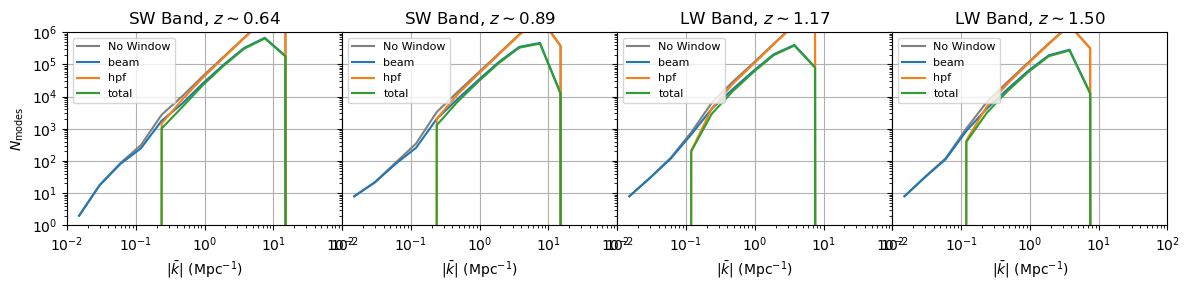

In [45]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharex=True, sharey=True, gridspec_kw={'wspace': 0})
axs = axs.flatten()
kwargs = {}
for i in range(4):
    axs[i].plot(kbincenters, nmodes_ones[i], label='No Window', **kwargs, color="gray")
    axs[i].plot(kbincenters, nmodes_wbeams[i], label='beam', **kwargs)
    axs[i].plot(kbincenters, nmodes_whpfs[i], label='hpf', **kwargs)
    axs[i].plot(kbincenters, nmodes_total[i], label='total', **kwargs)
    axs[i].set_xlabel(r'$|\bar k|$ (Mpc$^{-1}$)')
    axs[i].set_title(f'{bands[i]} Band, ' r'$z\sim$' f'{CALCZs[i]:.2f}')
    axs[i].set_aspect('auto')
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].grid(True)
    axs[i].set_xlim(1e-2, 1e2)
    axs[i].set_ylim(1e0, 1e6)
    if i == 0:
        axs[i].set_ylabel(r'$N_\text{modes}$')
    leg = axs[i].legend(loc='upper left', ncol=1, fontsize=8)
    for lh in leg.legend_handles: 
        lh.set_alpha(1)
plt.tight_layout()
plt.show()
# plt.savefig("../figs/nmodes_binned.png", bbox_inches='tight')
# plt.close()